In [1]:
# Setup & imports

import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
from IPython.display import display

# Custom Module Imports
from src.utils import data_loader, evaluation
from src.utils.training import trees
from src.utils.preprocessing.embeddings import external, base

In [2]:
# Configuration
COHORT_NAME = "mimic_cohort_NF_30_days"
DATA_DIR = project_root / "data" / COHORT_NAME
CV_FOLDS_DIR = DATA_DIR / "cv_folds"

# Embeddings (URLs)
GITHUB_BASE = "https://github.com/kaneplusplus/icd-10-cm-embedding/raw/main/embedding-data/"
EMBEDDING_FILES = {
    10: "icd-10-cm-2022-0010.csv.gz",
    50: "icd-10-cm-2022-0050.csv.gz",
    100: "icd-10-cm-2022-0100.csv.gz",
    1000: "icd-10-cm-2022-1000.csv.gz"
}

# Load Master Data
cohort_path = str(DATA_DIR / f"{COHORT_NAME}.csv.gz")
codes_path  = str(DATA_DIR / f"{COHORT_NAME}_icd_codes_upto.csv.gz")

df_target, df_codes, valid_ids = data_loader.load_processed_data(cohort_path, codes_path)

# Load Fold Files
fold_files = data_loader.get_fold_files(str(CV_FOLDS_DIR))

print(f"Data Loaded: {len(valid_ids)} patients")
print(f"Target Distribution:\n{df_target['label'].value_counts()}")


 Data Loaded. Total Patients in Cohort: 5308
Data Loaded: 5308 patients
Target Distribution:
label
0    5052
1     256
Name: count, dtype: int64


In [3]:
# Using factory functions from 'src.utils.training.trees'

models_map = {
    "XGBoost": trees.get_xgboost_model(),
    "RandomForest": trees.get_rf_model(),
    "CatBoost": trees.get_catboost_model()
}

In [4]:
# Main Execution Loop

leaderboard = []
dims_to_test = [10, 50, 100, 1000]

print(f"--- Starting Embedding Evaluation (Dimensions: {dims_to_test}) ---")

# Pre-calculate Sequences
sequences_dict = base.prepare_sequences(df_codes)

# Align Targets
y_aligned = df_target.set_index('hadm_id')['label']

for dim in dims_to_test:
    filename = EMBEDDING_FILES[dim]
    url = f"{GITHUB_BASE}{filename}"
    
    print(f"\n[Processing Dimension: {dim}]")
    
    # Load Embeddings
    embedding_lookup = external.load_pretrained_embeddings(url)
    
    if embedding_lookup is None:
        print(f"Skipping dim {dim} due to load error.")
        continue
        
    # Vectorize Patients
    X_matrix = base.vectorize_patients(
        hadm_ids=valid_ids, sequences_dict=sequences_dict, embedding_lookup=embedding_lookup, vector_size=dim
    )
    
    # Convert to DataFrame
    X_data = pd.DataFrame(X_matrix, index=valid_ids)
    
    # Run Cross-Validation
    for model_name, model_template in models_map.items():
        print(f"   Training {model_name}...", end=" ")
        
        avg_scores = evaluation.cross_validate(
            model_template=model_template,
            X_data=X_data,
            y=y_aligned,
            fold_files=fold_files,
            load_fold_func=data_loader.load_single_fold,
            train_func=trees.train_model
        )
        
        print(f"AUC: {avg_scores['AUC']:.4f}")
        
        record = {
            "Dimension": dim,
            "Model": model_name,
            **avg_scores
        }
        leaderboard.append(record)

print("\n--- Evaluation Complete ---")

--- Starting Embedding Evaluation (Dimensions: [10, 50, 100, 1000]) ---

[Processing Dimension: 10]
Loading embeddings from: https://github.com/kaneplusplus/icd-10-cm-embedding/raw/main/embedding-data/icd-10-cm-2022-0010.csv.gz...
 Loaded 72750 vectors.
   Training XGBoost... AUC: 0.5611
   Training RandomForest... AUC: 0.5866
   Training CatBoost... AUC: 0.5628

[Processing Dimension: 50]
Loading embeddings from: https://github.com/kaneplusplus/icd-10-cm-embedding/raw/main/embedding-data/icd-10-cm-2022-0050.csv.gz...
 Loaded 72750 vectors.
   Training XGBoost... AUC: 0.6147
   Training RandomForest... AUC: 0.6498
   Training CatBoost... AUC: 0.6319

[Processing Dimension: 100]
Loading embeddings from: https://github.com/kaneplusplus/icd-10-cm-embedding/raw/main/embedding-data/icd-10-cm-2022-0100.csv.gz...
 Loaded 72750 vectors.
   Training XGBoost... AUC: 0.6220
   Training RandomForest... AUC: 0.6431
   Training CatBoost... AUC: 0.6175

[Processing Dimension: 1000]
Loading embeddings

In [5]:
# Process and Display Results

# Convert leaderboard to DataFrame
results_df = pd.DataFrame(leaderboard)

# Sort by AUC to find the winner
results_df = results_df.sort_values(by="AUC", ascending=False)

# Display Top Configurations
print("\n=== Leaderboard (Top Configurations) ===")
cols = ["Dimension", "Model", "AUC"]
display(results_df[cols].head(10))

# Identify Best
best_row = results_df.iloc[0]
print(f"\n Best Configuration: {best_row['Model']} (Dim={best_row['Dimension']}), AUC: {best_row['AUC']:.4f}")



=== Leaderboard (Top Configurations) ===


,Dimension,Model,AUC
4,50,RandomForest,0.649822
10,1000,RandomForest,0.647868
7,100,RandomForest,0.643129
5,50,CatBoost,0.631884
6,100,XGBoost,0.621971
11,1000,CatBoost,0.618112
8,100,CatBoost,0.617460
3,50,XGBoost,0.614691
9,1000,XGBoost,0.601931
1,10,RandomForest,0.586645



 Best Configuration: RandomForest (Dim=50), AUC: 0.6498


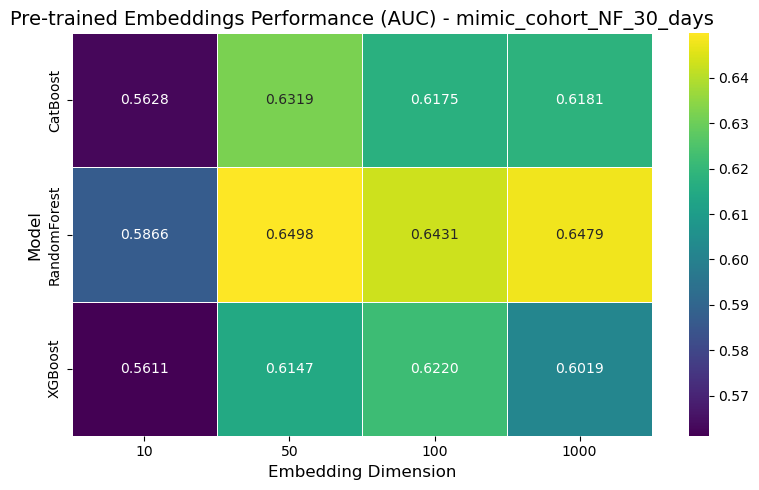

In [6]:
# Visualization (Heatmap)

evaluation.plot_performance_heatmap(
    leaderboard=leaderboard,
    metric="AUC",
    title=f"Pre-trained Embeddings Performance (AUC) - {COHORT_NAME}"
)